In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import numpy as np
from vector_quantize_pytorch import ResidualVQ

from typing import Union, List, Tuple

In [2]:
class CausalConv1d(nn.Conv1d):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.causal_padding = self.dilation[0] * (self.kernel_size[0]-1)
        
    def forward(self, x):
        px = F.pad(x, [self.causal_padding, 0])
        return self._conv_forward(px, self.weight, self.bias)

# derived from https://github.com/wesbz/SoundStream/blob/main/net.py
class CausalConvTranspose1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, **kwargs):
        
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.causal_padding = kernel_size - 1
        
        self.conv = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride, **kwargs)

    def forward(self, x):
        n = x.shape[-1]
        out = self.conv(x)
        out = out[..., :(n * self.stride)] # remove padding from right

        return out

In [3]:
class SSResidualUnit(nn.Module):
    
    def __init__(self, channels:int, dilation:int):
        
        super(SSResidualUnit, self).__init__()
        
        self.channels = channels
        self.dilation = dilation
        
        self.sequence = nn.Sequential(
            CausalConv1d(in_channels=channels, out_channels=channels, kernel_size=7, dilation=dilation),
            nn.ELU(),
            nn.Conv1d(channels, channels, kernel_size=1)
        )
        
    def forward(self, x):
        h = self.sequence(x)
        return x + h
    
s = SSResidualUnit(2, 7)
x = torch.randn((1, 2, 64))
s.sequence[0](x).shape

torch.Size([1, 2, 64])

In [4]:
class SSEncoderBlock(nn.Module):
    
    def __init__(self, channels:int, stride:int):
        
        super(SSEncoderBlock, self).__init__()
        
        self.channels = channels
        self.stride = stride
        
        self.resid_0 = SSResidualUnit(self.channels // 2, dilation = 1)
        self.resid_1 = SSResidualUnit(self.channels // 2, dilation = 3)
        self.resid_2 = SSResidualUnit(self.channels // 2, dilation = 9)
        self.activation = nn.ELU()
        
        self.out_conv = CausalConv1d(in_channels=self.channels // 2, out_channels=self.channels, kernel_size=2*self.stride, stride=self.stride)
        
    def forward(self, x):
        x0 = self.activation(self.resid_0(x))
        x1 = self.activation(self.resid_0(x0))
        x2 = self.activation(self.resid_0(x1))
        out = self.out_conv(x2)
        
        return out
    
se = SSEncoderBlock(4, 2)
x = torch.randn((1, 2, 4096))
se(x).shape

torch.Size([1, 4, 2048])

In [5]:
class SSEncoder(nn.Module):
    
    def __init__(self, in_channels:int, channels:int, embedding_dims:int):
        
        super(SSEncoder, self).__init__()
        
        self.in_channels = in_channels
        self.channels = channels
        self.embedding_dims = embedding_dims
        
        self.in_conv = CausalConv1d(in_channels=self.in_channels, out_channels=self.channels, kernel_size=7)
        
        self.encoder_block_0 = SSEncoderBlock(self.channels * 2, 2)
        self.encoder_block_1 = SSEncoderBlock(self.channels * 4, 4)
        self.encoder_block_2 = SSEncoderBlock(self.channels * 8, 5)
        self.encoder_block_3 = SSEncoderBlock(self.channels * 16, 8)
        self.activation = nn.ELU()
        
        self.out_conv = CausalConv1d(in_channels=self.channels * 16, out_channels=self.embedding_dims, kernel_size=3)
        
    def forward(self, x):
        
        h = self.activation(self.in_conv(x))
        h0 = self.activation(self.encoder_block_0(h))
        h1 = self.activation(self.encoder_block_1(h0))
        h2 = self.activation(self.encoder_block_2(h1))
        h3 = self.activation(self.encoder_block_3(h2))
        
        out = self.out_conv(h3)
        
        return out
    
sse = SSEncoder(1, 4, 128)
sse(torch.randn(1, 1, 44100)).shape

torch.Size([1, 128, 138])

In [6]:
class SSDecoderBlock(nn.Module):
    
    def __init__(self, channels:int, stride:int):
        
        super(SSDecoderBlock, self).__init__()
        
        self.channels = channels
        self.stride = stride
        
        self.in_conv = CausalConvTranspose1d(in_channels=2*self.channels, out_channels=self.channels, kernel_size=2*self.stride, stride=self.stride)
        
        self.resid_0 = SSResidualUnit(self.channels, dilation = 1)
        self.resid_1 = SSResidualUnit(self.channels, dilation = 3)
        self.resid_2 = SSResidualUnit(self.channels, dilation = 9)
        self.activation = nn.ELU()
        
    def forward(self, x):
        x0 = self.activation(self.in_conv(x))
        x1 = self.activation(self.resid_0(x0))
        x2 = self.activation(self.resid_1(x1))
        out = self.resid_2(x2)
        
        return out
    
se = SSDecoderBlock(8, 2)
x = torch.randn((1, 16, 64))
se(x).shape

torch.Size([1, 8, 128])

In [7]:
class SSDecoder(nn.Module):
    
    def __init__(self, out_channels:int, channels:int, embedding_dims:int):
        
        super(SSDecoder, self).__init__()
        
        self.out_channels = out_channels
        self.channels = channels
        self.embedding_dims = embedding_dims
        
        self.in_conv = CausalConv1d(in_channels=self.embedding_dims, out_channels=self.channels * 16, kernel_size=7, stride=1)
        
        self.encoder_block_0 = SSDecoderBlock(self.channels * 8, 8)
        self.encoder_block_1 = SSDecoderBlock(self.channels * 4, 5)
        self.encoder_block_2 = SSDecoderBlock(self.channels * 2, 4)
        self.encoder_block_3 = SSDecoderBlock(self.channels, 2)
        self.activation = nn.ELU()
        
        self.out_conv = CausalConv1d(in_channels=self.channels, out_channels=self.out_channels, kernel_size=7)
        
        
    def forward(self, x):
        
        h = self.activation(self.in_conv(x))
        h0 = self.activation(self.encoder_block_0(h))
        h1 = self.activation(self.encoder_block_1(h0))
        h2 = self.activation(self.encoder_block_2(h1))
        h3 = self.activation(self.encoder_block_3(h2))
        out = self.out_conv(h3)
        
        return out
    
dec = SSDecoder(1, 8, 512)
x = torch.randn((1, 512, 51))
dec(x).shape

torch.Size([1, 1, 16320])

In [8]:
clamped_log = lambda x: torch.log(x.clamp(min = 1e-20))

def gumbel_noise(t):
    noise = torch.zeros_like(t).uniform_(0, 1)
    return -clamped_log(-clamped_log(noise))

def gumbel_sample(t, temperature = 1., dim = -1):
    if temperature == 0:
        return t.argmax(dim = dim)

    return ((t / temperature) + gumbel_noise(t)).argmax(dim = dim)

gumbel_sample(torch.randn(3,52,128), dim=-1)

tensor([[ 68,  68, 122, 125,  96, 100,  87,   2,  55,  18,  12,  97, 126, 123,
           5,  47,  27, 122,  94,  95,  67,  41, 105,  36, 111,  54,  51,  17,
          60,  94,  66,  74,  42, 117,  52, 104, 114,  86,  72,   9, 108,  10,
          62,  99,  81,   4, 113,  78,  30,  74,  72,  73],
        [100,  97,   7,  77,  83, 115,  57, 110,  16, 108,  11,  77, 104, 101,
           1,  49,  74,  15,  46,  89,  59,  13,  85,  53, 120,  57,  95,  38,
          27,  13,  15,  79,  40,  88, 101,  45,  16,   4,  20,  61,  79,  76,
          73,  15, 123,  14,  39,  37,  83,  20,  11,  72],
        [ 25,  66,  70,  74, 112,  94, 124,  31, 102,  83,  37,  71,   7,  98,
         107, 111,   4,  81,  46,  44,  91, 104,  31,   9, 126, 110,   1,  31,
          73,  44,  35,  29, 109,  72,  21,  21,  25,  97,  81,  48,  59,  53,
           0,  23,  11,  79, 106,  11,  23,  53, 106,  51]])

In [9]:

class EmbeddingQuantizer(nn.Module):

    def __init__(self, codebook_size:int, embedding_dims:int, gumbel_sample:bool=True) -> None:
        
        super(EmbeddingQuantizer, self).__init__()

        self.embedding_dims = embedding_dims
        self.codebook_size = codebook_size
        self.gumbel_sample = gumbel_sample

        self.embeddings = nn.Embedding(self.codebook_size, self.embedding_dims)
        
        self.embeddings.apply(self._init_weights)
        
    def _init_weights(self, m):
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, x):

        B, C, T = x.shape

        reshape_inputs = x.permute(0, 2, 1).contiguous() # embed by channel values (BTC)
        reshape_inputs = reshape_inputs.view(-1, self.embedding_dims) # reshape to embedding dimensions (B, E)

        # calculate distances between all inputs and embeddings
        if self.gumbel_sample:
            distances = -torch.cdist(reshape_inputs, self.embeddings.weight)
            embedding_indexes = gumbel_sample(distances)
        else:
            xs = (reshape_inputs**2).sum(dim=1, keepdim=True)
            ys = (self.embeddings.weight**2).sum(dim=1)
            dots = reshape_inputs @ self.embeddings.weight.t()
            distances = (xs + ys) - (2 * dots)
            embedding_indexes = torch.argmin(distances, dim=1).unsqueeze(1)
        

        # get embedding indices and quantize
        quantized_embeddings = self.embeddings(embedding_indexes).view(B, T, C).permute(0, 2, 1).contiguous()

        loss = F.mse_loss(x, quantized_embeddings)

        return quantized_embeddings, embedding_indexes.squeeze(-1), loss
    
    
class ResidualEmbeddingQuantizer(nn.Module):
    
    def __init__(self, codebook_size:int, embedding_dims:int, total_codebooks:int, gumbel_sample:bool=True) -> None:
        
        super(ResidualEmbeddingQuantizer, self).__init__()
        
        self.embedding_dims = embedding_dims
        self.codebook_size = codebook_size
        self.total_codebooks = total_codebooks
        
        self.codebooks = nn.Sequential(*[EmbeddingQuantizer(self.codebook_size, self.embedding_dims, gumbel_sample) for _ in range(self.total_codebooks)])
        
    def forward(self, x):
        
        y_hat = torch.zeros_like(x).to(x.device)
        cumulative_loss = torch.tensor(0.).to(x.device)
        all_codes = []
        
        for codebook in self.codebooks:
            residual_embs, codes, loss = codebook(x)
            y_hat = y_hat + residual_embs
            x = x - residual_embs
            cumulative_loss += loss
            all_codes.append(codes)
        
        all_codes = torch.cat(all_codes).view(len(all_codes),-1)
            
        return y_hat, all_codes, cumulative_loss
        
        
    

eq = ResidualEmbeddingQuantizer(1024, 128, 5)
x = torch.randn((1, 128, 51))
embs, codes, loss = eq(x)
embs.shape, codes.shape, loss

(torch.Size([1, 128, 51]),
 torch.Size([5, 51]),
 tensor(5.0909, grad_fn=<AddBackward0>))

In [10]:
class SoundStream(nn.Module):
    
    def __init__(self, in_channels:int, channels:int, embedding_dims:int, codebook_size:int, total_codebooks:int, use_internal_vq:bool=False):
        
        super(SoundStream, self).__init__()
        
        self.encoder = SSEncoder(in_channels, channels, embedding_dims)
        if use_internal_vq:
            self.quantizer = ResidualEmbeddingQuantizer(codebook_size, embedding_dims, total_codebooks)
        else:
            self.quantizer = ResidualVQ(
                num_quantizers=total_codebooks, dim=embedding_dims, 
                codebook_size=codebook_size, kmeans_init=True, 
                kmeans_iters=100, threshold_ema_dead_code=2
            )
        
        self.decoder = SSDecoder(in_channels, channels, embedding_dims)
        
    def forward(self, x):
        
        h = self.encoder(x).permute(0, 2, 1)
        embs, codes, q_loss = self.quantizer(h)
        out = self.decoder(embs.permute(0, 2, 1))
        
        return out, embs, codes, q_loss
    
model = SoundStream(1, 4, 128, 512, 5)
x = torch.randn(1, 1, 22080)
out, embs, codes, q_loss = model(x)
x.shape, out.shape, embs.shape, codes.shape, q_loss

(torch.Size([1, 1, 22080]),
 torch.Size([1, 1, 22080]),
 torch.Size([1, 69, 128]),
 torch.Size([1, 69, 5]),
 tensor([[0., 0., 0., 0., 0.]], grad_fn=<StackBackward0>))

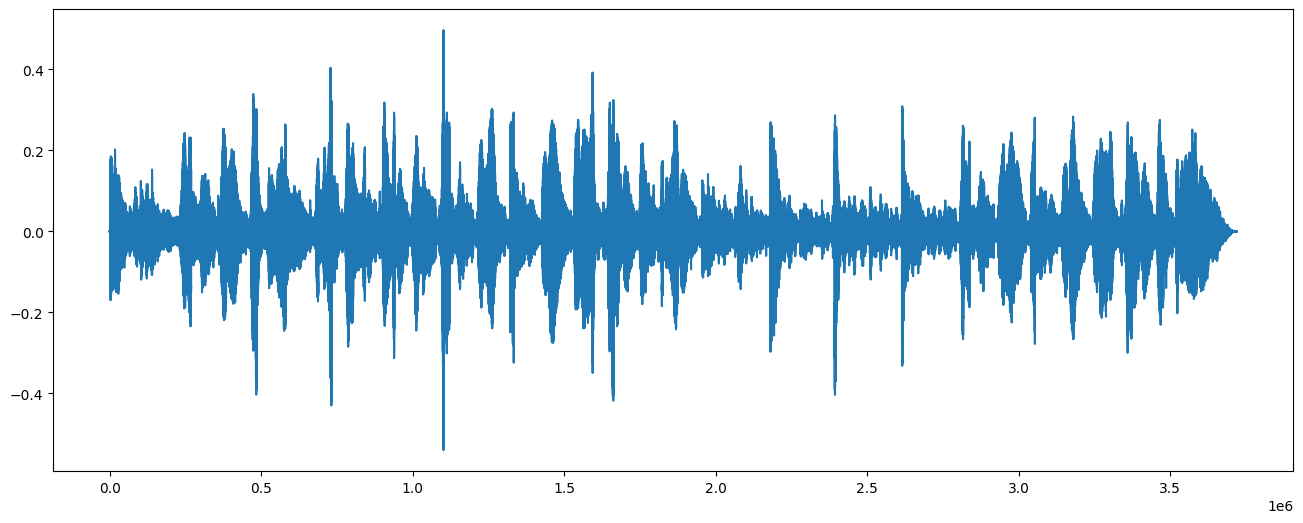

In [11]:
# not using stft for now
import librosa

x, sr = librosa.load('../data/song_01.wav', sr=22080)

plt.figure(figsize=(16,6))
plt.plot(x)

In [12]:
sample_size = sr * 2
x = torch.tensor(x)
cutoff = x.shape[0] - (x.shape[0] % sample_size)
xs = x[:cutoff].view(-1, sample_size)
xs = xs[:,None,...]
xs.shape

torch.Size([84, 1, 44160])

In [13]:
out = model(xs[:3])[0]
out.shape

torch.Size([3, 1, 44160])

torch.Size([44160])

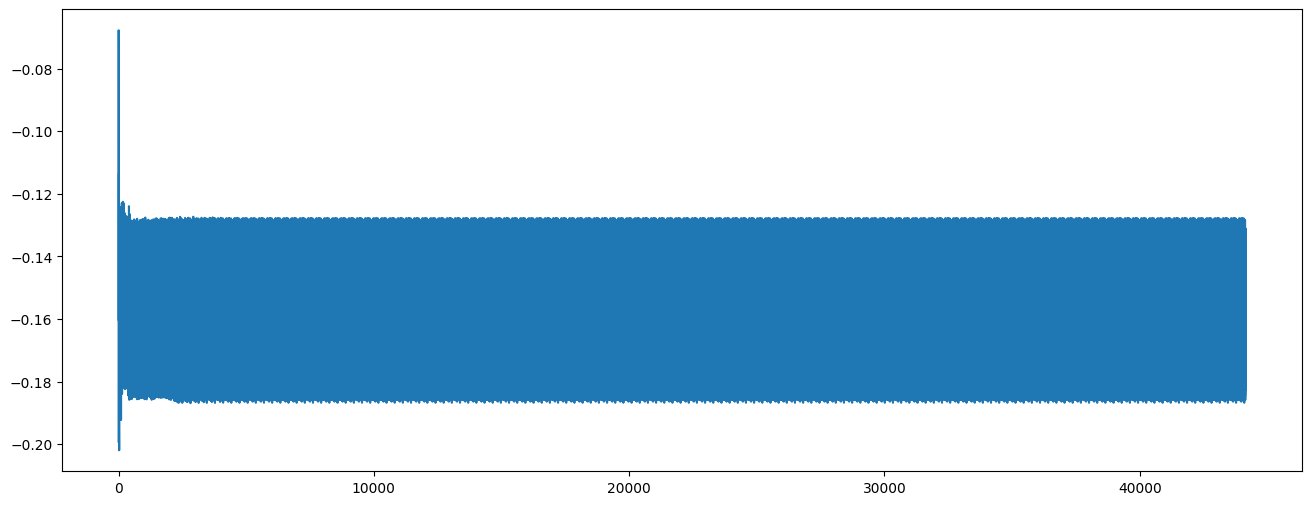

In [14]:
plt.figure(figsize=(16,6))
untrained_sample = out[1].squeeze().detach()
plt.plot(untrained_sample)
untrained_sample.shape

In [15]:
from IPython.display import Audio

Audio(xs[61].squeeze().tolist(), rate=sr)

In [16]:
librosa.feature.melspectrogram(xs[61].squeeze().numpy()).shape

/tmp/ipykernel_174265/4242972296.py:1: FutureWarning: Pass y=[ 0.00542665  0.00237741  0.00036258 ... -0.00879708 -0.00952459
 -0.00944493] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.feature.melspectrogram(xs[61].squeeze().numpy()).shape


(128, 87)

In [17]:
from typing import Optional
from torchaudio.transforms import MelSpectrogram

class STFTLoss(nn.Module):
    
    def __init__(self, n_fft:int, window_size:Optional[int] = None, hop_size:Optional[int] = None):
        
        super(STFTLoss, self).__init__()
        
        self.n_fft = n_fft
        self.window_size = window_size
        self.hop_size = hop_size
        
    def forward(self, x, t):
        
        x1 = torch.stft(x, self.n_fft)
        t1 = torch.stft(t, self.n_fft)
        
        return F.l1_loss(x1, t1)
    
def spectral_reconstruction_loss(x, G_x, eps=1e-4):
    L = 0
    for i in range(6,12):
        s = 2**i
        alpha_s = (s/2)**0.5
        melspec = MelSpectrogram(sample_rate=sr, n_fft=s, hop_length=s//4, n_mels=8, wkwargs={"device": device}).to(device)
        S_x = melspec(x)
        S_G_x = melspec(G_x)
        
        loss = (S_x-S_G_x).abs().sum() + alpha_s*(((torch.log(S_x.abs()+eps)-torch.log(S_G_x.abs()+eps))**2).sum(dim=-2)**0.5).sum()
        L += loss
    
    return L

In [ ]:
device = "cuda:1"
BASE = (1, 32, 512, 1024, 8)
MED = (1, 16, 256, 512, 4)
SMALL = (1, 8, 128, 256, 4)
model = SoundStream(*SMALL)
model.to(device)

#criterion = STFTLoss((sr // 2) - 1)
criterion = spectral_reconstruction_loss
optimizer = torch.optim.Adam(model.parameters())
steps = 1000
pbar = tqdm(total=steps)
losses = []
BATCH_SIZE = 32

for i in range(steps):
    pbar.update(1)
    batch_ix = torch.randint(0, xs.shape[0], (BATCH_SIZE,))
    inputs = xs[batch_ix].to(device)
    out, embs, codes, q_loss = model(inputs)

    #sc_loss, mag_loss = criterion(out.squeeze(), inputs.squeeze())
    #loss = q_loss + sc_loss + mag_loss
    recon_loss = criterion(out.squeeze(), inputs.squeeze())
    loss = recon_loss + q_loss.sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    pbar.set_description(desc=f"average loss: {(sum(losses[-100:])/min(100,len(losses))):.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
plt.plot(torch.tensor(losses).view(-1, 10).mean(1))

In [ ]:
sample_ix = 61
out, embs, codes, q_loss =  model(xs[sample_ix][None,...].to(device))
#
plt.plot(out.squeeze().cpu().detach())

In [ ]:
Audio(out.squeeze().tolist(), rate=sr)

In [ ]:
Audio(xs[sample_ix].squeeze().tolist(), rate=sr)

In [ ]:
out.squeeze()[:30], xs[sample_ix].squeeze()[:30]